# ANCOM: WGS

In [8]:
library(tidyverse)
library(magrittr)
source("/Users/Cayla/ANCOM/scripts/ancom_v2.1.R")

## T2

In [9]:
t2 <- read_csv('https://github.com/bryansho/PCOS_WGS_16S_metabolome/raw/master/DESEQ2/WGS/T2/T2_filtered_greater_00001.csv')
head(t2,n=1)

Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ──────────────────────────────────────────────────
cols(
  .default = col_double(),
  X1 = col_character()
)
ℹ Use `spec()` for the full column specifications.




X1,570_T2,571_T2,572_T2,573_T2,574_T2,575_T2,576_T2,577_T2,578_T2,⋯,594_T2,595_T2,596_T2,597_T2,598_T2,599_T2,600_T2,601_T2,602_T2,603_T2
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
s_Bacteroides_caecimuris,527122,293835,276306,670919,535250,309961,451212,545790,204205,⋯,429686,619379,431181,339492,529517,190934,321198,285499,595056,404745


In [10]:
t2.meta <- read_csv('https://github.com/bryansho/PCOS_WGS_16S_metabolome/raw/master/DESEQ2/WGS/T2/Deseq2_T2_mapping.csv')
head(t2.meta,n=1)


── Column specification ──────────────────────────────────────────────────
cols(
  Sample = col_character(),
  Treatment = col_character(),
  Timepoint = col_double()
)




Sample,Treatment,Timepoint
<chr>,<chr>,<dbl>
570_T2,Placebo,2


In [11]:
# subset data
t2.meta.PvL <- t2.meta %>% filter(Treatment == 'Placebo' | Treatment == 'Let')
t2.PvL <- t2 %>% select(X1, any_of(t2.meta.PvL$Sample)) %>% column_to_rownames('X1')

t2.meta.LvLCH  <- t2.meta %>% filter(Treatment == 'Let' | Treatment == 'CoL')
t2.LvLCH <- t2 %>% select(X1, any_of(t2.meta.LvLCH$Sample)) %>% column_to_rownames('X1')

### Placebo vs. Let

In [12]:
# Data Preprocessing

# feature_table is a df/matrix with features as rownames and samples in columns
feature_table <- t2.PvL 

# character vector/column containing sample IDs
sample_var <- "Sample"

# grouping variable to detect structural zeros and outliers
group_var <- "Treatment"

# 0 < fraction < 1. For each feature, observations with proportion of mixture 
# distribution < out_cut will be detected as outlier zeros;
# > (1 - out_cut) will be detected as outlier values
out_cut <- 0.05

# 0 < fraction < 1. Features with proportion of zeros > zero_cut are removed.
zero_cut <- 0.90 

# samples with library size < lib_cut will be excluded in the analysis
lib_cut <- 0

# TRUE indicates a taxon would be classified as a structural zero in the 
# corresponding experimental group using its asymptotic lower bound. More 
# specifically, ```neg_lb = TRUE``` indicates you are using both criteria 
# stated in section 3.2 of [ANCOM-II]
# (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5682008/) to detect structural
# zeros; Otherwise, ```neg_lb = FALSE``` will only use the equation 1 in 
# section 3.2 of [ANCOM-II](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5682008/)
# for declaring structural zeros.
neg_lb <- TRUE

prepro <- feature_table_pre_process(feature_table, t2.meta.PvL, sample_var, group_var, 
                                   out_cut, zero_cut, lib_cut, neg_lb)

# Preprocessed feature table
feature_table1 <- prepro$feature_table

# Preprocessed metadata
meta_data1 <- prepro$meta_data 

# Structural zero info
struc_zero1 <- prepro$structure_zeros 

In [13]:
# Run ANCOM

# name of the main variable of interest (character)
main_var <- "Treatment"

p_adj_method <- "BH" # number of taxa > 10, therefore use Benjamini-Hochberg correction

alpha <- 0.05

# character string representing the formula for adjustment
adj_formula <- NULL 

# character string representing the formula for random effects in lme
rand_formula <- NULL

t_start <- Sys.time()

res <- ANCOM(feature_table1, meta_data1, struc_zero1, main_var, p_adj_method, 
            alpha, adj_formula, rand_formula)

t_end <- Sys.time()
t_end - t_start 

# write output to file
# output contains the "W" statistic for each taxa - a count of the number of times 
# the null hypothesis is rejected for each taxa
# detected_x are logicals indicating detection at specified FDR cut-off
write_csv(res$out, "2021-07-25_WGS_T2_PvL_ANCOM_data.csv")

Time difference of 4.672676 hours

In [35]:
n_taxa <- ifelse(is.null(struc_zero1), nrow(feature_table1), sum(apply(struc_zero1, 1, sum) == 0))
res$fig + scale_y_continuous(sec.axis = sec_axis(~ . * 100 / n_taxa, name = 'W proportion'))
ggsave(filename = paste(lubridate::today(),'volcano_WGS_T2_PvL.pdf',sep='_'), bg = 'transparent', device = 'pdf', dpi = 'retina')

In [15]:
# to find most significant taxa, I will sort the data 
# 1) y (W statistic)
# 2) according to the absolute value of CLR mean difference
sig <- res$fig$data %>% 
    mutate(taxa_id = str_split_fixed(res$fig$data$taxa_id, pattern='s_', n=2)[,2]) %>% # remove leading 's_'
    arrange(desc(y), desc(abs(x))) %>% 
    filter(y >= (0.7*n_taxa), !is.na(taxa_id)) # keep significant taxa, remove unidentified taxa

write.csv(sig, paste(lubridate::today(),'SigFeatures_WGS_T2_PvL.csv',sep='_'))

In [37]:
# save features with W > 0 
non.zero <- res$fig$data %>% 
    arrange(desc(y), desc(abs(x))) %>% 
    mutate(taxa_id = str_split_fixed(res$fig$data$taxa_id, pattern='s_', n=2)[,2], # remove leading 's_'
           W.proportion = y/(n_taxa-1)) %>% # add W    
    filter(y > 0) %>% 
    rowid_to_column()
    
write.csv(non.zero, paste(lubridate::today(),'NonZeroW_Features_WGS_T2_PvL.csv',sep='_'))

Saving 10 x 7 in image



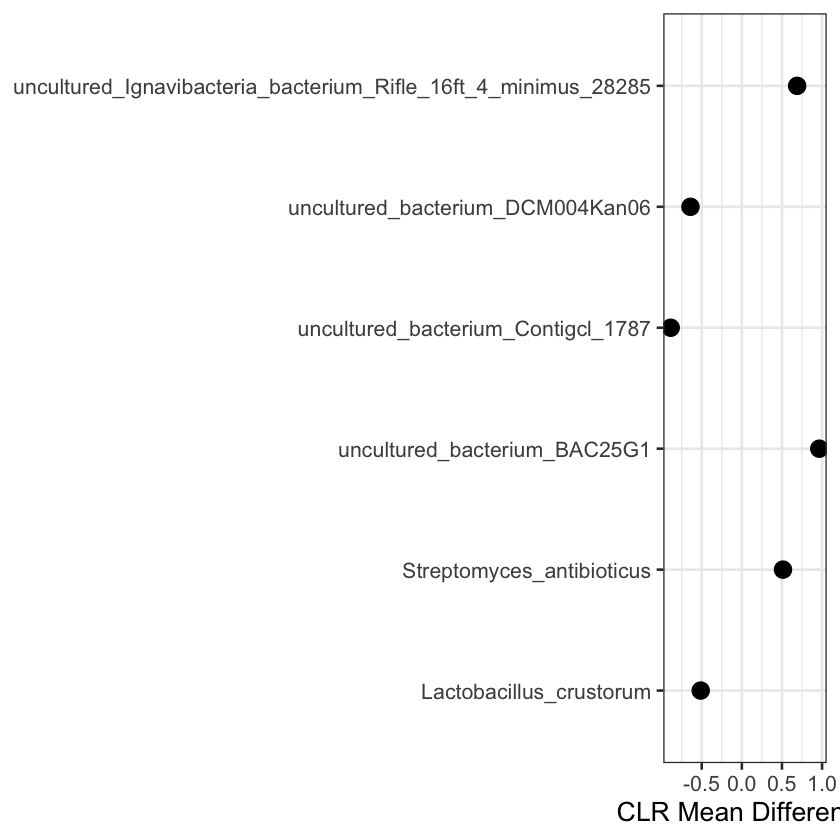

In [16]:
# plot top 20 taxa
sig %>% 
    slice_head(n=20) %>% 
    ggplot(aes(x, taxa_id)) +
    geom_point(aes(size = 1)) +
    theme_bw(base_size = 16) + 
    guides(size = FALSE) +
    labs(x = 'CLR Mean Difference', y = NULL)

ggsave(filename = paste(lubridate::today(),'Top20_WGS_T2_PvL.pdf',sep='_'), bg = 'transparent', device = 'pdf', dpi = 'retina', width = 10)

### Let v Let-co-housed

In [17]:
# Data Preprocessing

feature_table <- t2.LvLCH 
sample_var <- "Sample"
group_var <- "Treatment"
out_cut <- 0.05
zero_cut <- 0.90 
lib_cut <- 0
neg_lb <- TRUE

prepro <- feature_table_pre_process(feature_table, t2.meta.LvLCH, sample_var, group_var, 
                                   out_cut, zero_cut, lib_cut, neg_lb)

# Preprocessed feature table
feature_table2 <- prepro$feature_table

# Preprocessed metadata
meta_data2 <- prepro$meta_data 

# Structural zero info
struc_zero2 <- prepro$structure_zeros 

In [18]:
# Run ANCOM

# name of the main variable of interest (character)
main_var <- "Treatment"

p_adj_method <- "BH" # number of taxa > 10, therefore use Benjamini-Hochberg correction

alpha <- 0.05

# character string representing the formula for adjustment
adj_formula <- NULL 

# character string representing the formula for random effects in lme
rand_formula <- NULL

t_start <- Sys.time()

res2 <- ANCOM(feature_table2, meta_data2, struc_zero2, main_var, p_adj_method, 
            alpha, adj_formula, rand_formula)

t_end <- Sys.time()
t_end - t_start 

# write output to file
# output contains the "W" statistic for each taxa - a count of the number of times 
# the null hypothesis is rejected for each taxa
# detected_x are logicals indicating detection at specified FDR cut-off
write_csv(res2$out, "2021-07-25_WGS_T2_LvLCH_ANCOM_data.csv")

Time difference of 4.628646 hours

In [38]:
n_taxa <- ifelse(is.null(struc_zero2), nrow(feature_table2), sum(apply(struc_zero2, 1, sum) == 0))
res2$fig + scale_y_continuous(sec.axis = sec_axis(~ . * 100 / n_taxa, name = 'W proportion'))
ggsave(filename = paste(lubridate::today(),'volcano_WGS_T2_LvLCH.pdf',sep='_'), bg = 'transparent', device = 'pdf', dpi = 'retina')

In [39]:
# save features with W > 0 
non.zero <- res2$fig$data %>% 
    arrange(desc(y), desc(abs(x))) %>% 
    mutate(taxa_id = str_split_fixed(res2$fig$data$taxa_id, pattern='s_', n=2)[,2], # remove leading 's_'
           W.proportion = y/(n_taxa-1)) %>% # add W    
    filter(y > 0) %>% 
    rowid_to_column()
    
write.csv(non.zero, paste(lubridate::today(),'NonZeroW_Features_WGS_T2_LvLCH.csv',sep='_'))

In [20]:
# to find most significant taxa, I will sort the data 
# 1) y (W statistic)
# 2) according to the absolute value of CLR mean difference
sig <- res2$fig$data %>% 
    mutate(taxa_id = str_split_fixed(res2$fig$data$taxa_id, pattern='s_', n=2)[,2]) %>% # remove leading 's_'
    arrange(desc(y), desc(abs(x))) %>% 
    filter(y >= (0.7*n_taxa), !is.na(taxa_id)) # keep significant taxa, remove unidentified taxa

write.csv(sig, paste(lubridate::today(),'SigFeatures_WGS_T2_LvLCH.csv',sep='_'))

Saving 10 x 7 in image



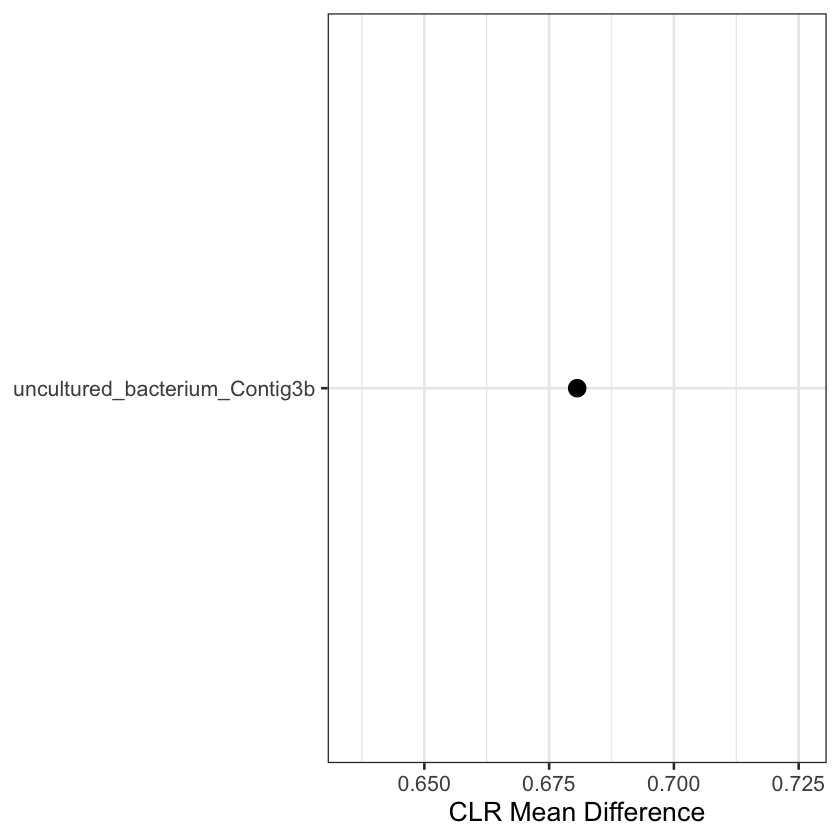

In [21]:
# plot top 20 taxa
sig %>% 
    slice_head(n=20) %>% 
    ggplot(aes(x, taxa_id)) +
    geom_point(aes(size = 1)) +
    theme_bw(base_size = 16) + 
    guides(size = FALSE) +
    labs(x = 'CLR Mean Difference', y = NULL)

ggsave(filename = paste(lubridate::today(),'Top20_WGS_T2_LvLCH.pdf',sep='_'), bg = 'transparent', device = 'pdf', dpi = 'retina', width = 10)

## T5

In [22]:
t5 <- read_csv('https://github.com/bryansho/PCOS_WGS_16S_metabolome/raw/master/DESEQ2/WGS/T5/T5_filtered_greater_00001.csv')
head(t5,n=1)

Warning message:
“Missing column names filled in: 'X1' [1]”

── Column specification ──────────────────────────────────────────────────
cols(
  .default = col_double(),
  X1 = col_character()
)
ℹ Use `spec()` for the full column specifications.




X1,T5_570,T5_571,T5_572,T5_573,T5_574,T5_575,T5_576,T5_577,T5_578,⋯,T5_594,T5_595,T5_596,T5_597,T5_598,T5_599,T5_600,T5_601,T5_602,T5_603
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
s_Bacteroides_caecimuris,261830,332966,467983,331443,397470,339082,656671,282436,327767,⋯,488950,579482,496134,610076,377147,505832,486990,745599,592120,245398


In [23]:
t5.meta <- read_csv('https://github.com/bryansho/PCOS_WGS_16S_metabolome/raw/master/DESEQ2/WGS/T5/Deseq2_T5_mapping.csv')
head(t5.meta,n=1)


── Column specification ──────────────────────────────────────────────────
cols(
  SampleID = col_character(),
  Treatment = col_character(),
  Timepoint = col_double()
)




SampleID,Treatment,Timepoint
<chr>,<chr>,<dbl>
T5_570,Placebo,5


In [24]:
# subset data
t5.meta.PvL <- t5.meta %>% filter(Treatment == 'Placebo' | Treatment == 'Let')
t5.PvL <- t5 %>% select(X1, any_of(t5.meta.PvL$SampleID)) %>% column_to_rownames('X1')

t5.meta.LvLCH  <- t5.meta %>% filter(Treatment == 'Let' | Treatment == 'CoL')
t5.LvLCH <- t5 %>% select(X1, any_of(t5.meta.LvLCH$SampleID)) %>% column_to_rownames('X1')

### Placebo v Let

In [25]:
# Data Preprocessing

feature_table <- t5.PvL 
sample_var <- "SampleID"
group_var <- "Treatment"
out_cut <- 0.05
zero_cut <- 0.90 
lib_cut <- 0
neg_lb <- TRUE

prepro <- feature_table_pre_process(feature_table, t5.meta.PvL, sample_var, group_var, 
                                   out_cut, zero_cut, lib_cut, neg_lb)

# Preprocessed feature table
feature_table3 <- prepro$feature_table

# Preprocessed metadata
meta_data3 <- prepro$meta_data 

# Structural zero info
struc_zero3 <- prepro$structure_zeros 

In [26]:
# Run ANCOM

# name of the main variable of interest (character)
main_var <- "Treatment"

p_adj_method <- "BH" # number of taxa > 10, therefore use Benjamini-Hochberg correction

alpha <- 0.05

# character string representing the formula for adjustment
adj_formula <- NULL 

# character string representing the formula for random effects in lme
rand_formula <- NULL

t_start <- Sys.time()

res3 <- ANCOM(feature_table3, meta_data3, struc_zero3, main_var, p_adj_method, 
            alpha, adj_formula, rand_formula)

t_end <- Sys.time()
t_end - t_start 

# write output to file
# output contains the "W" statistic for each taxa - a count of the number of times 
# the null hypothesis is rejected for each taxa
# detected_x are logicals indicating detection at specified FDR cut-off
write_csv(res3$out, "2021-07-25_WGS_T5_PvL_ANCOM_data.csv")

Time difference of 4.623009 hours

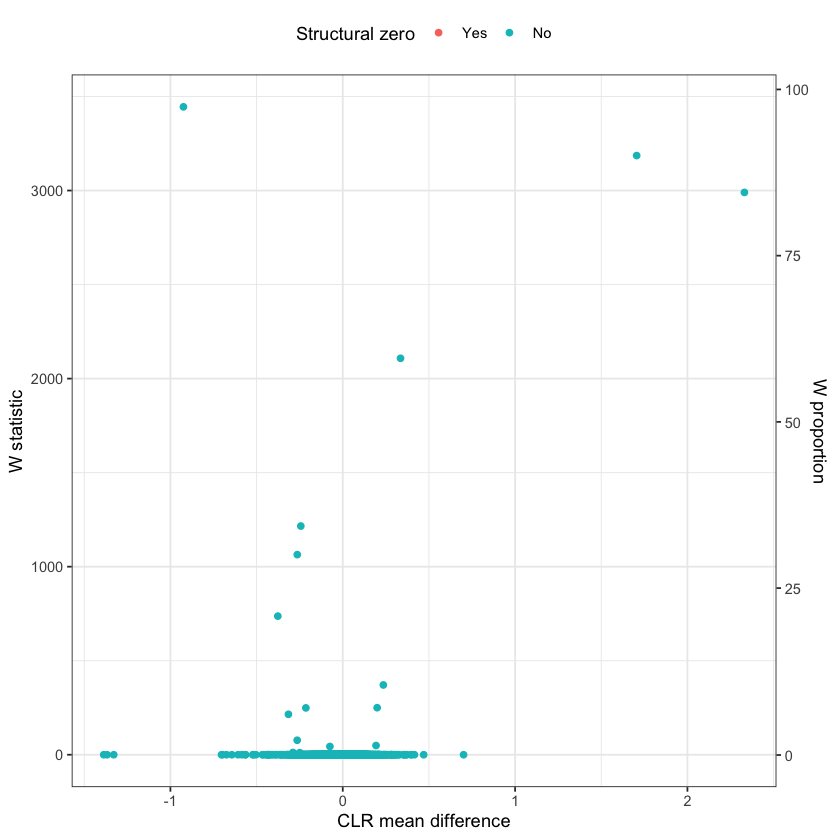

In [40]:
n_taxa <- ifelse(is.null(struc_zero3), nrow(feature_table3), sum(apply(struc_zero3, 1, sum) == 0))
res3$fig + scale_y_continuous(sec.axis = sec_axis(~ . * 100 / n_taxa, name = 'W proportion'))
ggsave(filename = paste(lubridate::today(),'volcano_WGS_T5_PvL.pdf',sep='_'), bg = 'transparent', device = 'pdf', dpi = 'retina')

In [41]:
# save features with W > 0 
non.zero <- res3$fig$data %>% 
    arrange(desc(y), desc(abs(x))) %>% 
    mutate(taxa_id = str_split_fixed(res3$fig$data$taxa_id, pattern='s_', n=2)[,2], # remove leading 's_'
           W.proportion = y/(n_taxa-1)) %>% # add W    
    filter(y > 0) %>% 
    rowid_to_column()
    
write.csv(non.zero, paste(lubridate::today(),'NonZeroW_Features_WGS_T5_PvL.csv',sep='_'))

In [28]:
# to find most significant taxa, I will sort the data 
# 1) y (W statistic)
# 2) according to the absolute value of CLR mean difference
sig <- res3$fig$data %>% 
    mutate(taxa_id = str_split_fixed(res3$fig$data$taxa_id, pattern='s_', n=2)[,2]) %>% # remove leading 's_'
    arrange(desc(y), desc(abs(x))) %>% 
    filter(y >= (0.7*n_taxa), !is.na(taxa_id)) # keep significant taxa, remove unidentified taxa

write.csv(sig, paste(lubridate::today(),'SigFeatures_WGS_T5_PvL.csv',sep='_'))

Saving 10 x 7 in image



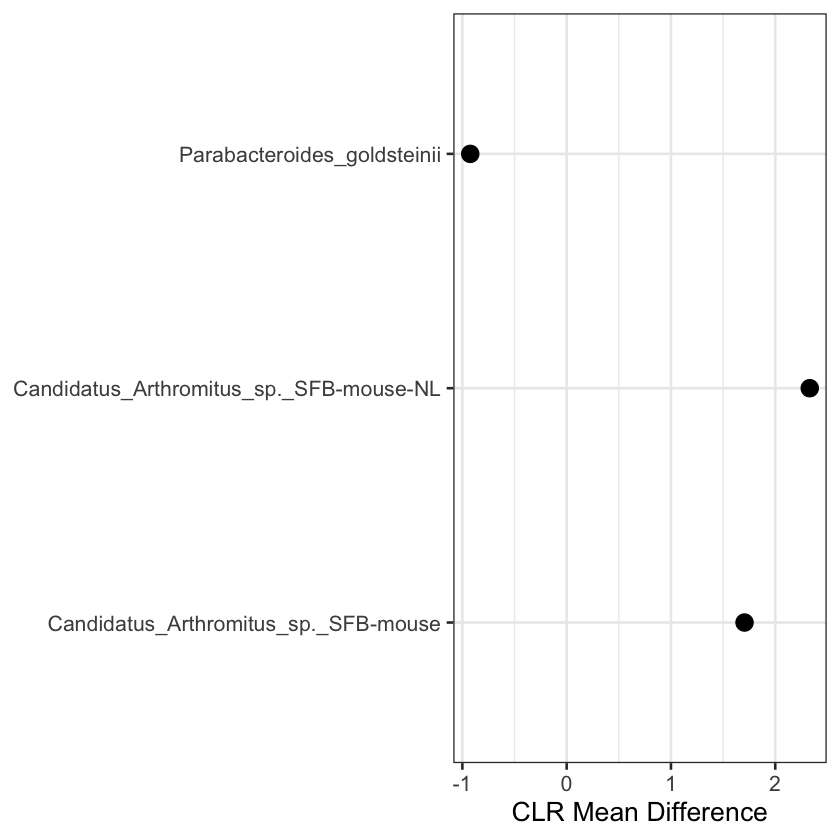

In [29]:
# plot top 20 taxa
sig %>% 
    slice_head(n=20) %>% 
    ggplot(aes(x, taxa_id)) +
    geom_point(aes(size = 1)) +
    theme_bw(base_size = 16) + 
    guides(size = FALSE) +
    labs(x = 'CLR Mean Difference', y = NULL)

ggsave(filename = paste(lubridate::today(),'Top20_WGS_T5_PvL.pdf',sep='_'), bg = 'transparent', device = 'pdf', dpi = 'retina', width = 10)

### Let v Let-co-housed

In [30]:
# Data Preprocessing

feature_table <- t5.LvLCH 
sample_var <- "SampleID"
group_var <- "Treatment"
out_cut <- 0.05
zero_cut <- 0.90 
lib_cut <- 0
neg_lb <- TRUE

prepro <- feature_table_pre_process(feature_table, t5.meta.LvLCH, sample_var, group_var, 
                                   out_cut, zero_cut, lib_cut, neg_lb)

# Preprocessed feature table
feature_table4 <- prepro$feature_table

# Preprocessed metadata
meta_data4 <- prepro$meta_data 

# Structural zero info
struc_zero4 <- prepro$structure_zeros 

In [31]:
# Run ANCOM

# name of the main variable of interest (character)
main_var <- "Treatment"

p_adj_method <- "BH" # number of taxa > 10, therefore use Benjamini-Hochberg correction

alpha <- 0.05

# character string representing the formula for adjustment
adj_formula <- NULL 

# character string representing the formula for random effects in lme
rand_formula <- NULL

t_start <- Sys.time()

res4 <- ANCOM(feature_table4, meta_data4, struc_zero4, main_var, p_adj_method, 
            alpha, adj_formula, rand_formula)

t_end <- Sys.time()
t_end - t_start 

# write output to file
# output contains the "W" statistic for each taxa - a count of the number of times 
# the null hypothesis is rejected for each taxa
# detected_x are logicals indicating detection at specified FDR cut-off
write_csv(res4$out, "2021-07-25_WGS_T5_LvLCH_ANCOM_data.csv")

Time difference of 4.590833 hours

Saving 7 x 7 in image



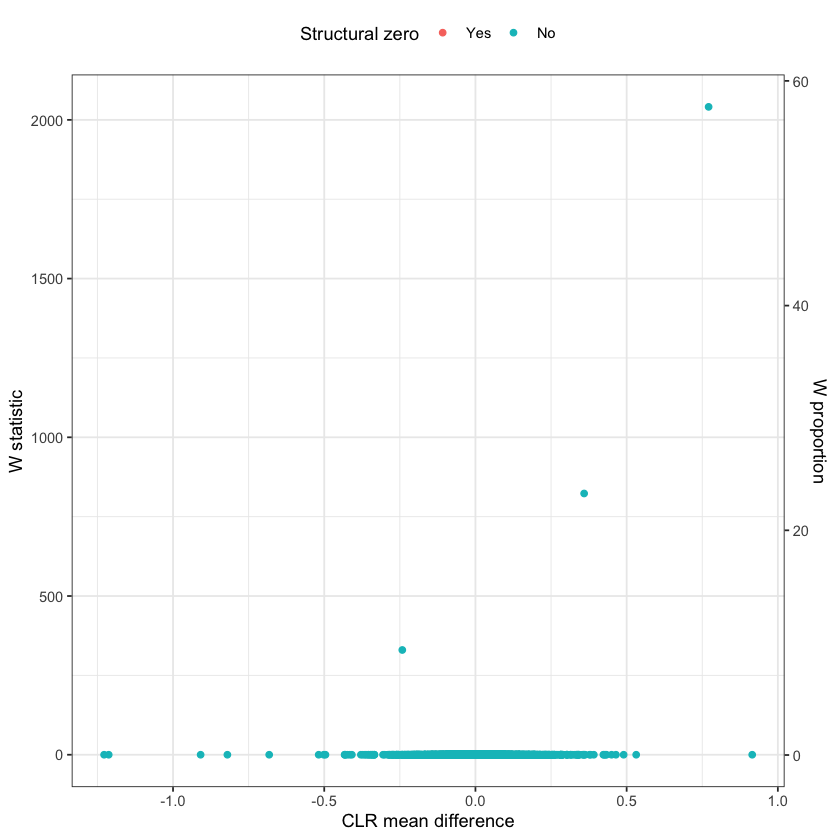

In [43]:
n_taxa <- ifelse(is.null(struc_zero4), nrow(feature_table4), sum(apply(struc_zero4, 1, sum) == 0))
res4$fig + scale_y_continuous(sec.axis = sec_axis(~ . * 100 / n_taxa, name = 'W proportion'))
ggsave(filename = paste(lubridate::today(),'volcano_WGS_T5_LvLCH.pdf',sep='_'), bg = 'transparent', device = 'pdf', dpi = 'retina')

In [44]:
# save features with W > 0 
non.zero <- res4$fig$data %>% 
    arrange(desc(y), desc(abs(x))) %>% 
    mutate(taxa_id = str_split_fixed(res4$fig$data$taxa_id, pattern='s_', n=2)[,2], # remove leading 's_'
           W.proportion = y/(n_taxa-1)) %>% # add W    
    filter(y > 0) %>% 
    rowid_to_column()
    
write.csv(non.zero, paste(lubridate::today(),'NonZeroW_Features_WGS_T5_LvLCH.csv',sep='_'))

In [45]:
# to find most significant taxa, I will sort the data 
# 1) y (W statistic)
# 2) according to the absolute value of CLR mean difference
sig <- res4$fig$data %>% 
    mutate(taxa_id = str_split_fixed(res4$fig$data$taxa_id, pattern='s_', n=2)[,2]) %>% # remove leading 's_'
    arrange(desc(y), desc(abs(x))) %>% 
    filter(y >= (0.7*n_taxa), !is.na(taxa_id)) # keep significant taxa, remove unidentified taxa

write.csv(sig, paste(lubridate::today(),'SigFeatures_WGS_T5_LvLCH.csv',sep='_'))

ERROR while rich displaying an object: Error: Aesthetics must be either length 1 or the same as the data (1): x and y

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_te

ERROR: Error: Aesthetics must be either length 1 or the same as the data (1): x and y


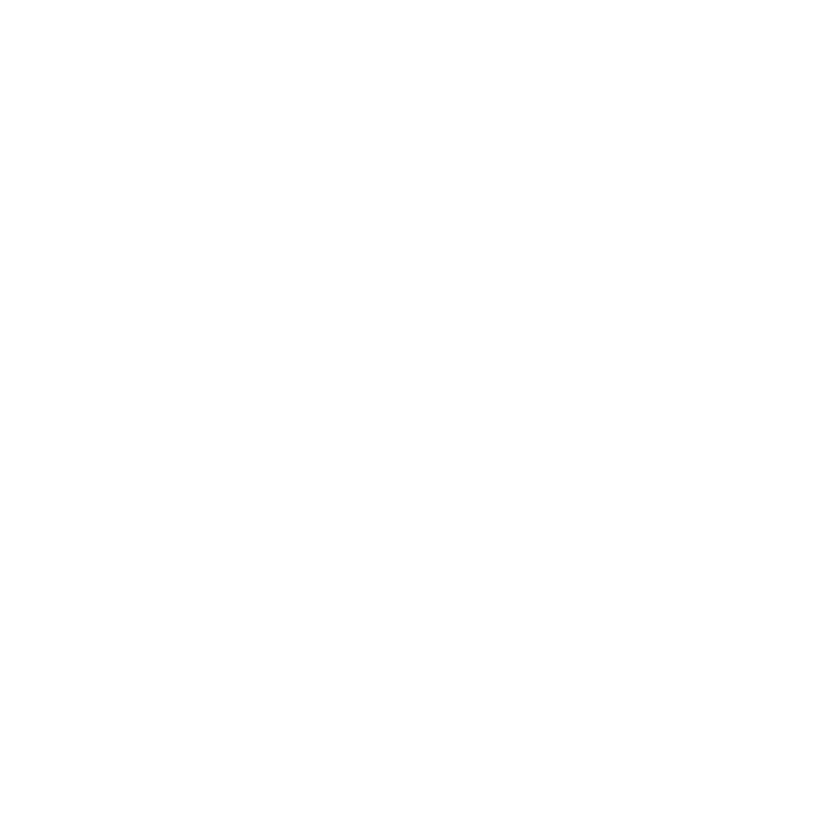

In [46]:
# plot top 20 taxa
sig %>% 
    slice_head(n=20) %>% 
    ggplot(aes(x, taxa_id)) +
    geom_point(aes(size = 1)) +
    theme_bw(base_size = 16) + 
    guides(size = FALSE) +
    labs(x = 'CLR Mean Difference', y = NULL)

ggsave(filename = paste(lubridate::today(),'Top20_WGS_T5_LvLCH.pdf',sep='_'), bg = 'transparent', device = 'pdf', dpi = 'retina', width=10)